#### Imports

In [55]:
# Geberal
import pandas as pd
import numpy as np
from numpy import argmax
import re 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Knowledge Graphs
import spacy
import spacy.cli
from spacy.matcher import Matcher 
import networkx as nx
from tqdm import tqdm

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional

# Model Diagnostics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# ! python -m spacy download en_core_web_lg
# spacy.cli.download("en_core_web_lg")

In [3]:
sns.set_context('talk')
pd.set_option('display.max_rows',None)

#### Data

In [28]:
class_corpus = pd.read_csv('/Users/dylanhayashi/Desktop/Northwestern/MSDS_453_Public/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv')

#### Preprocessing

In [29]:
nlp = spacy.load('en_core_web_lg')

In [30]:
class_corpus = class_corpus.rename(columns={
    'Genre of Movie':'Genre',
    'Review Type (pos or neg)':'Sentiment',
    'Text':'Raw Text'
})

In [31]:
# Data Wrangling

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def nlp_transformations(df):
    """
    Apply NLP transformations to a pandas DataFrame.
    Parameters: df (DataFrame): Input dataframe with a column named 'Text'.
    Returns: DataFrame: A new dataframe with added columns for each NLP transformation.
    """
    df['Tokens'] = df['Raw Text'].apply(word_tokenize)
    df['Normalized'] = df['Tokens'].apply(lambda x: [word.lower() for word in x])
    df['Lemmatized'] = df['Normalized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    df['No_Stop_Words'] = df['Lemmatized'].apply(lambda x: [word for word in x if word not in stop_words])
    df['Cleaned'] = df['No_Stop_Words'].apply(lambda x: [re.sub(r'[^a-zA-Z]', '', word) for word in x])
    df['Cleaned'] = df['Cleaned'].apply(lambda x: [word for word in x if word != ''])
    df['Text'] = df['Cleaned']
    return df

wrangled_data = nlp_transformations(class_corpus).sort_values(['Genre','Movie Title','Sentiment'])

#### Part 1 - Knowledge Graphs

#### Knowledge Graph Functions

In [10]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " " + prefix + " " + tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                   {'DEP':'prep', 'OP':"?"},
                   {'DEP':'agent', 'OP':"?"},  
                   {'POS':'ADJ', 'OP':"?"}] 
        
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except Exception as e:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

In [11]:
MOVIE_TO_EXPLORE = 'Taken'

In [12]:
movie_reviews = (class_corpus.loc[class_corpus['Movie Title'] == MOVIE_TO_EXPLORE, 'Raw Text']
                             .reset_index(drop=True))

#### Part 1A - Raw Text

#### Knowledge Graph - Single Review for Taken

100%|██████████| 29/29 [00:00<00:00, 132.95it/s]
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 148 (\x94) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


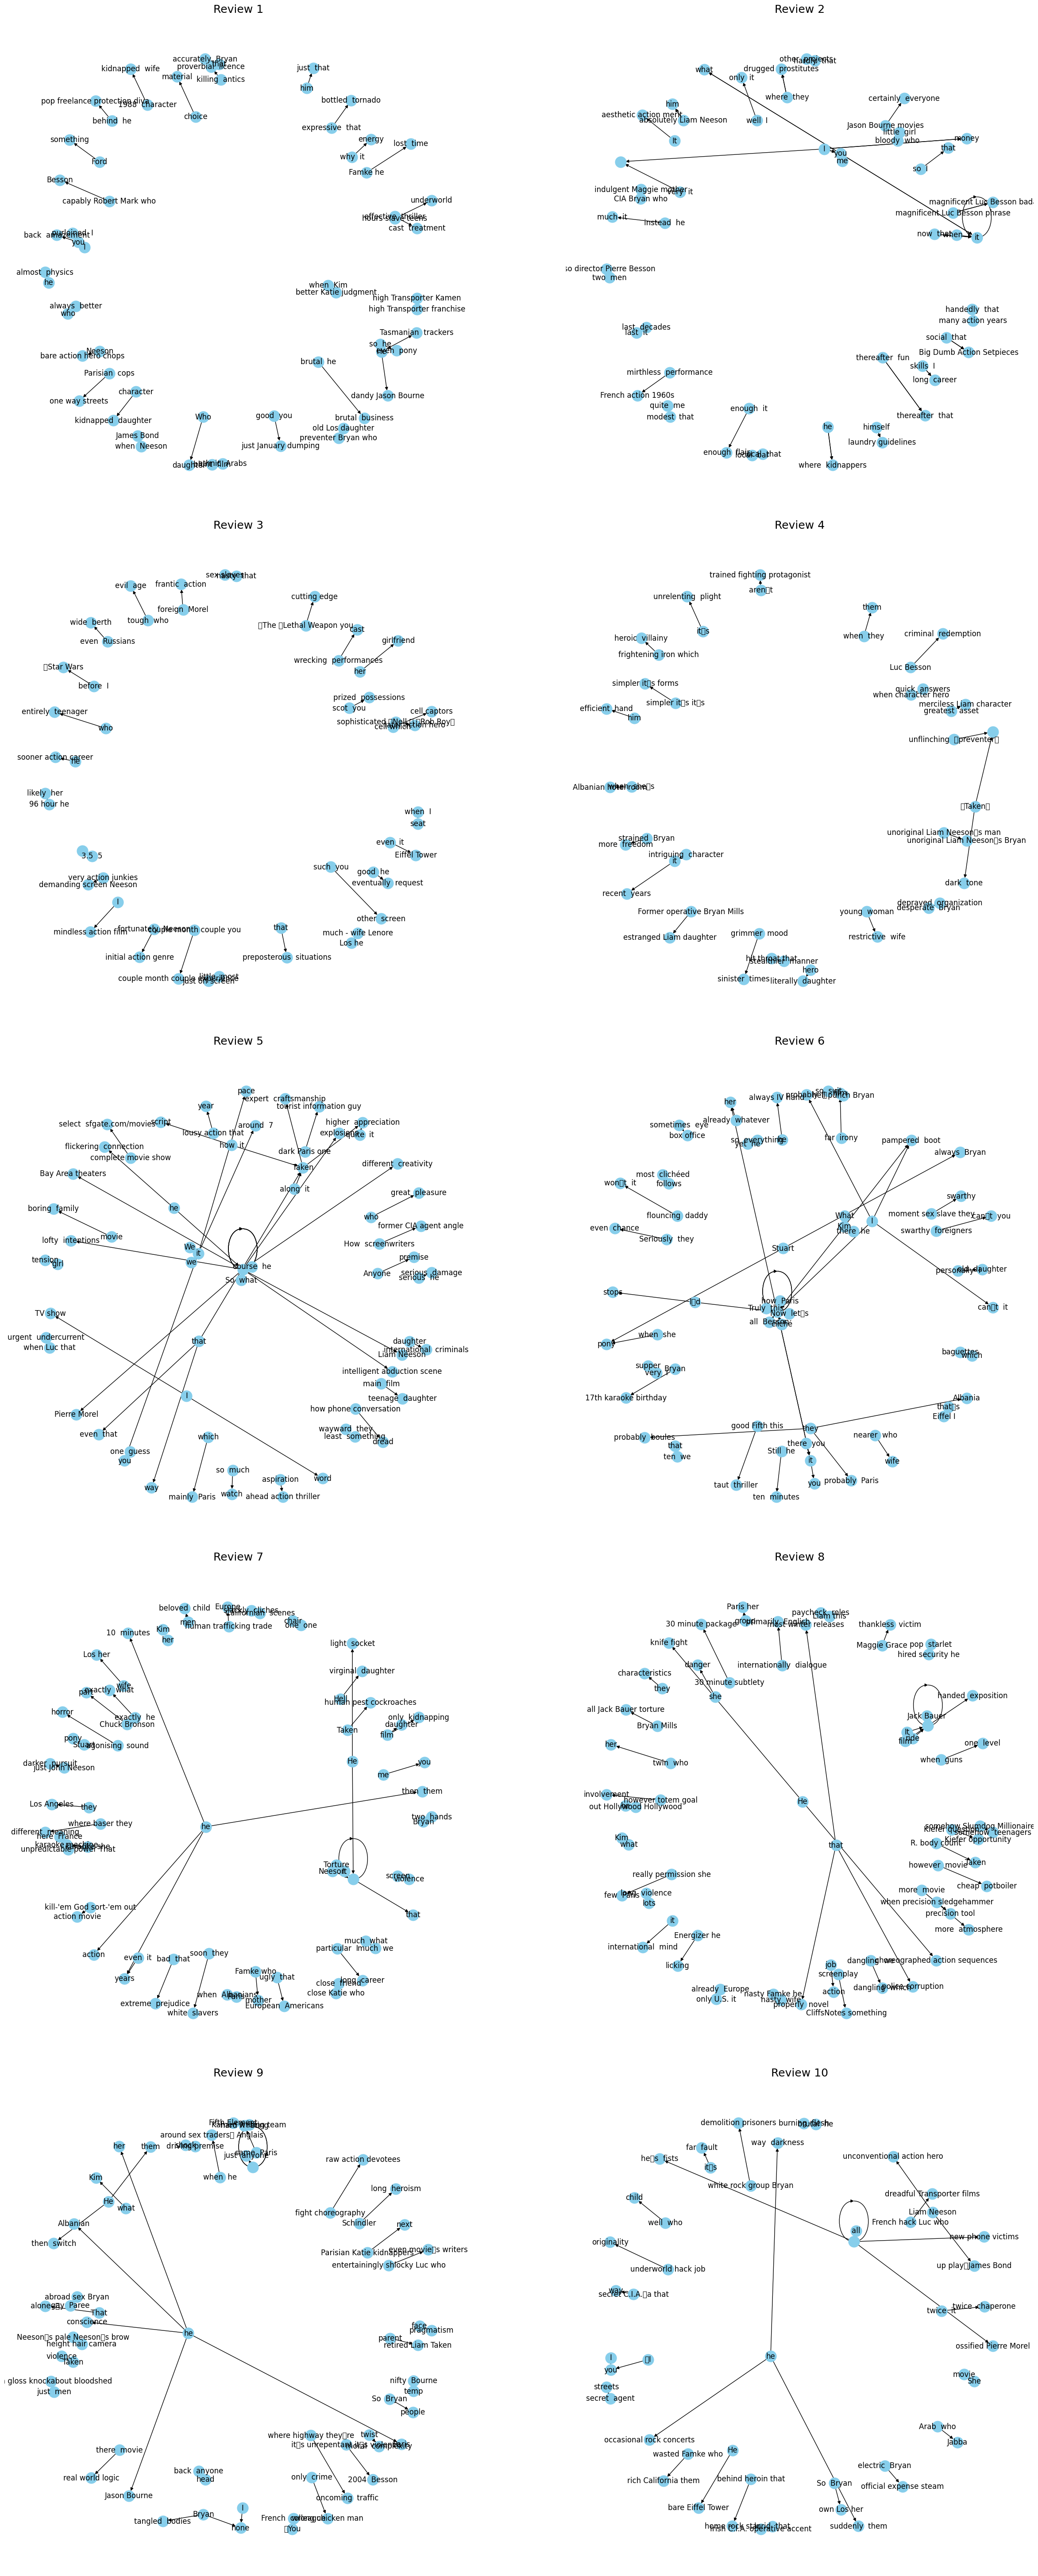

In [13]:
# Prepare the figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(30, 15 * 5))  # Adjust the size as needed
fig.subplots_adjust(hspace=0.05, wspace=0.2)

for i in range(10):
    doc = nlp(movie_reviews[i])

    doc_sents = [str(x) for x in list(doc.sents)]

    entity_pairs = []

    for sent in tqdm(doc_sents):
        entity_pairs.append(get_entities(sent))

    relations = [get_relation(sent) for sent in tqdm(doc_sents)]

    # extract subject
    source = [x[0] for x in entity_pairs]

    # extract object
    target = [x[1] for x in entity_pairs]

    kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

    # create a directed-graph from a dataframe
    G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

    # Choose the current subplot
    ax = axes[i // 2, i % 2]
    plt.sca(ax)
    
    pos = nx.spring_layout(G, seed=42)  # Using a fixed seed for consistent layout
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos, ax=ax)

    # Set the title for the current graph
    ax.set_title(f'Review {i + 1}')

# Show the plot
plt.show()


#### Knowledge Graph - All Reviews for Taken

100%|██████████| 382/382 [00:02<00:00, 140.45it/s]


NetworkXError: draw_networkx_edge_labels does not support multiedges.

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 147 (\x93) missing from current font.
  func(*args, **kwargs)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 148 (\x94) missing from current font.
  func(*args, **kwargs)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 146 (\x92) missing from current font.
  func(*args, **kwargs)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 14

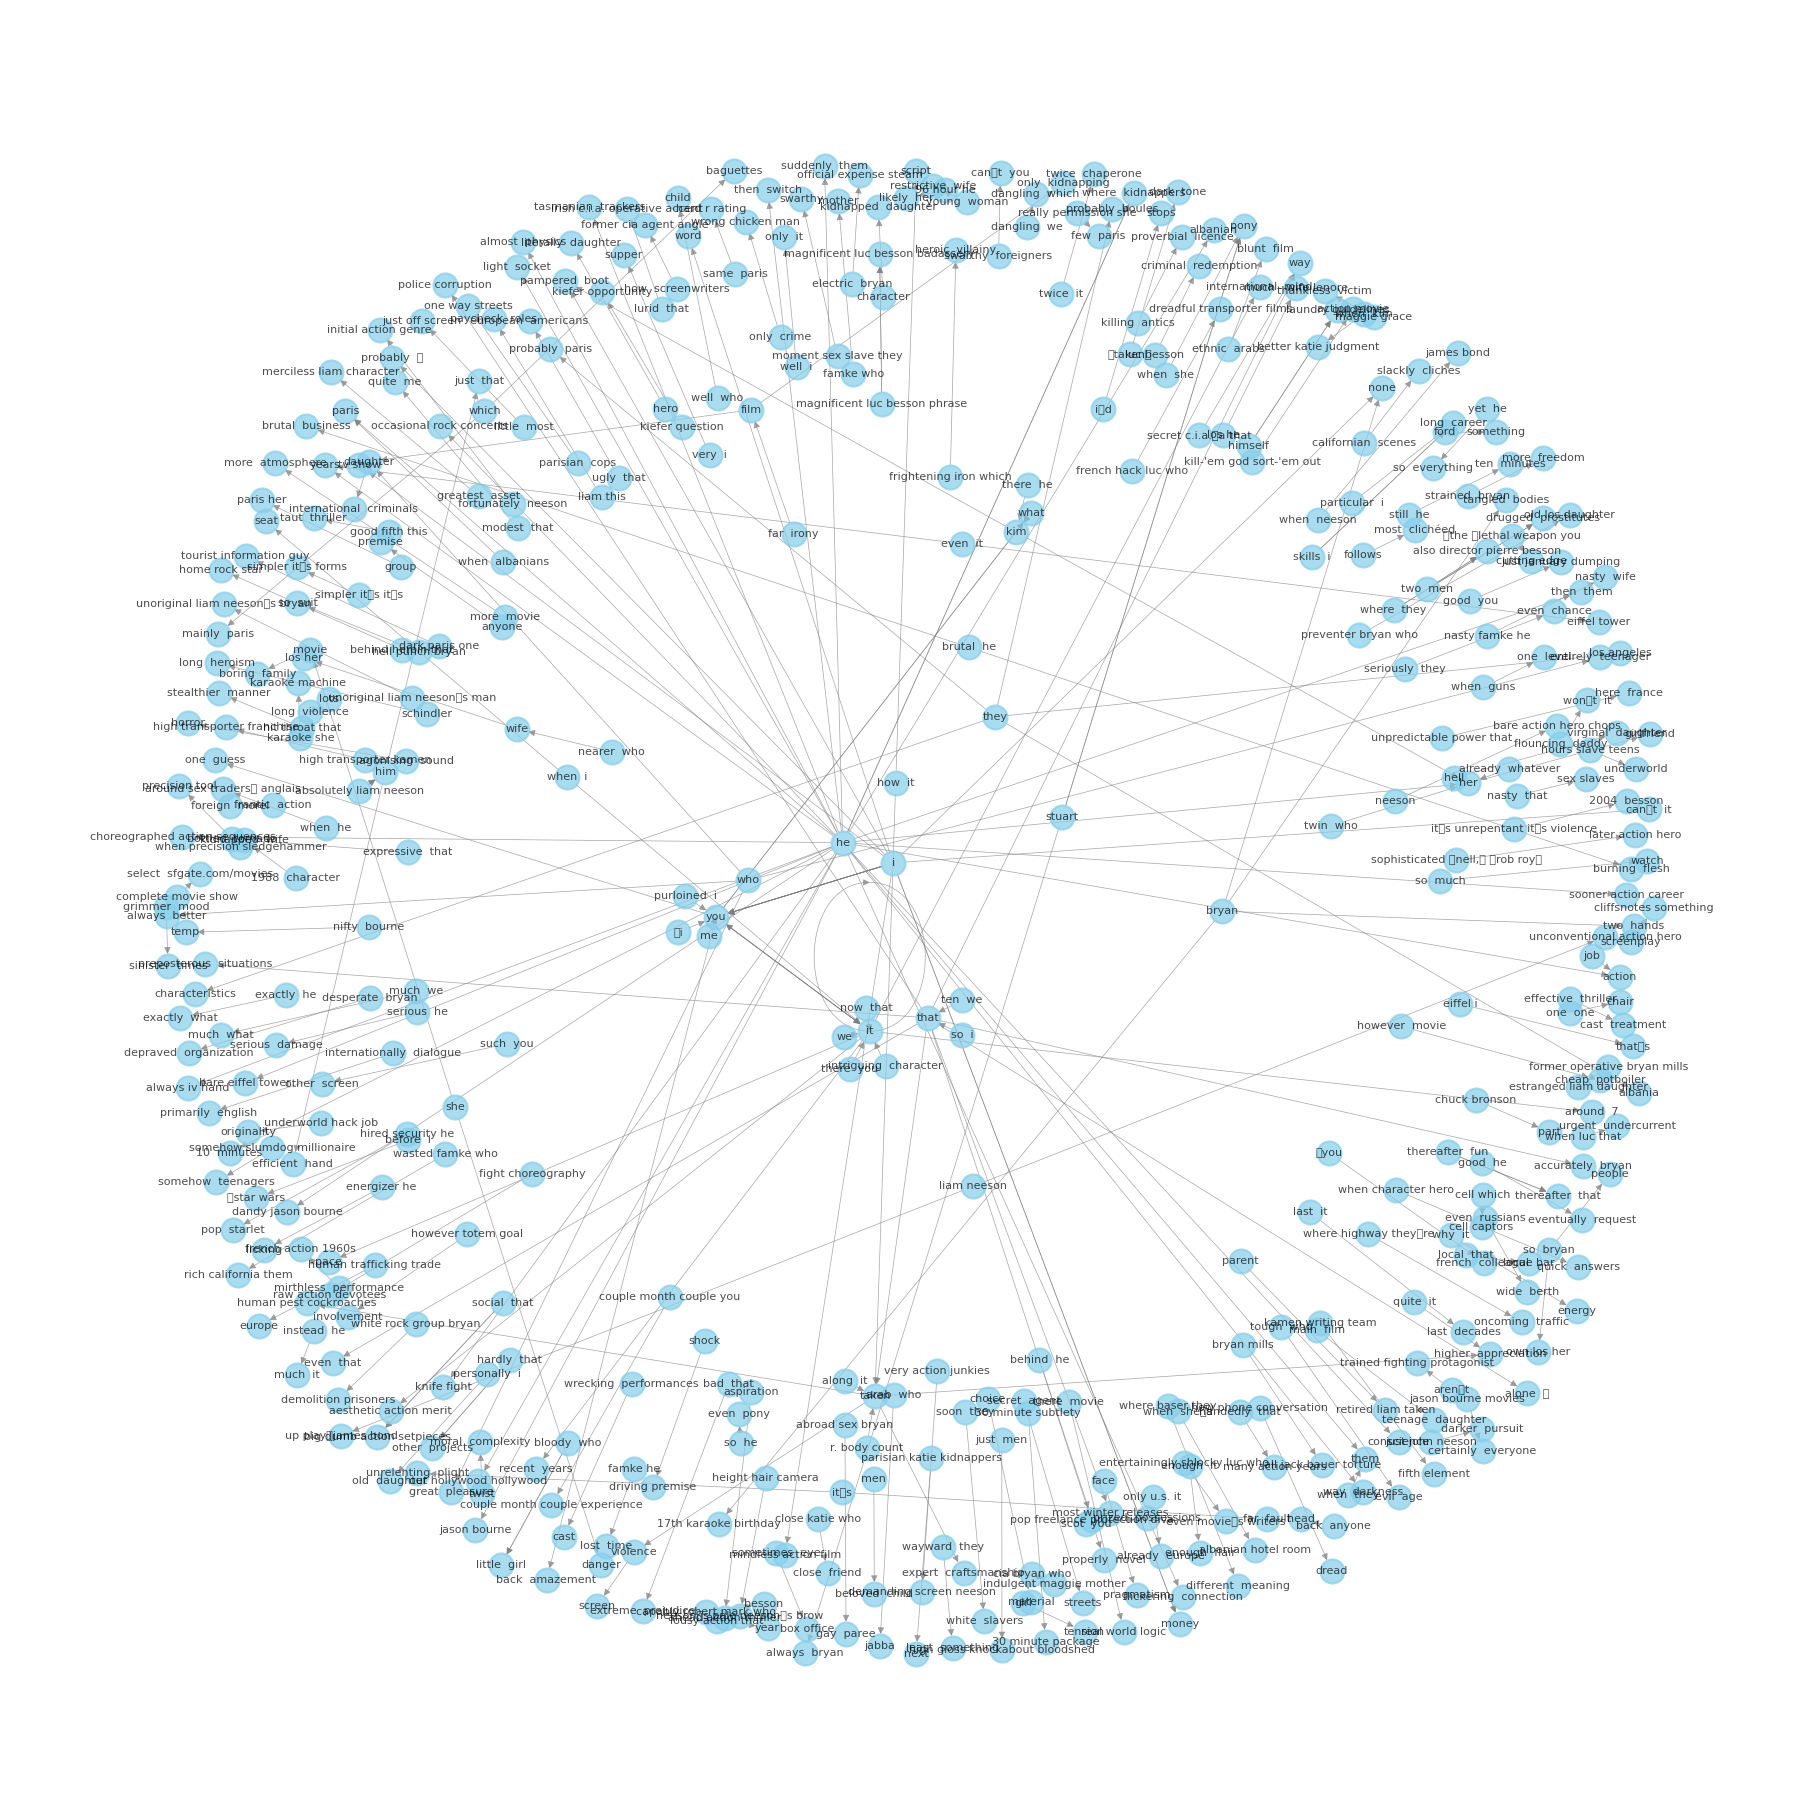

In [14]:
all_movie_reviews = ' '.join(movie_reviews)

doc = nlp(all_movie_reviews)

doc_sents = [str(x) for x in doc.sents]

entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

relations = [get_relation(i) for i in tqdm(doc_sents)]

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                            edge_attr=True, create_using=nx.MultiDiGraph())

# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(18,18))  # You can adjust the figure size as needed

# Define node positions using a layout of your choice
pos = nx.spring_layout(G, k=0.1)  # k regulates the distance between nodes

# Draw the graph with adjusted node and font sizes
nx.draw(G, pos,
        with_labels=True,
        node_color='skyblue',
        node_size=300,  # Smaller node size
        font_size=8,    # Smaller font size for node labels
        width=0.5,      # Thinner edges
        edge_color='gray',  # Edge color can be set to a lighter shade for better contrast
        arrowsize=10,   # Smaller arrow size
        alpha=0.7)      # Slightly transparent nodes and edges

# Optional: Add labels to edges if required (might clutter the graph if there are many edges)
edge_labels = nx.get_edge_attributes(G, 'edge')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.axis('off')  # Turn off the axis
plt.show()

#### Relations

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


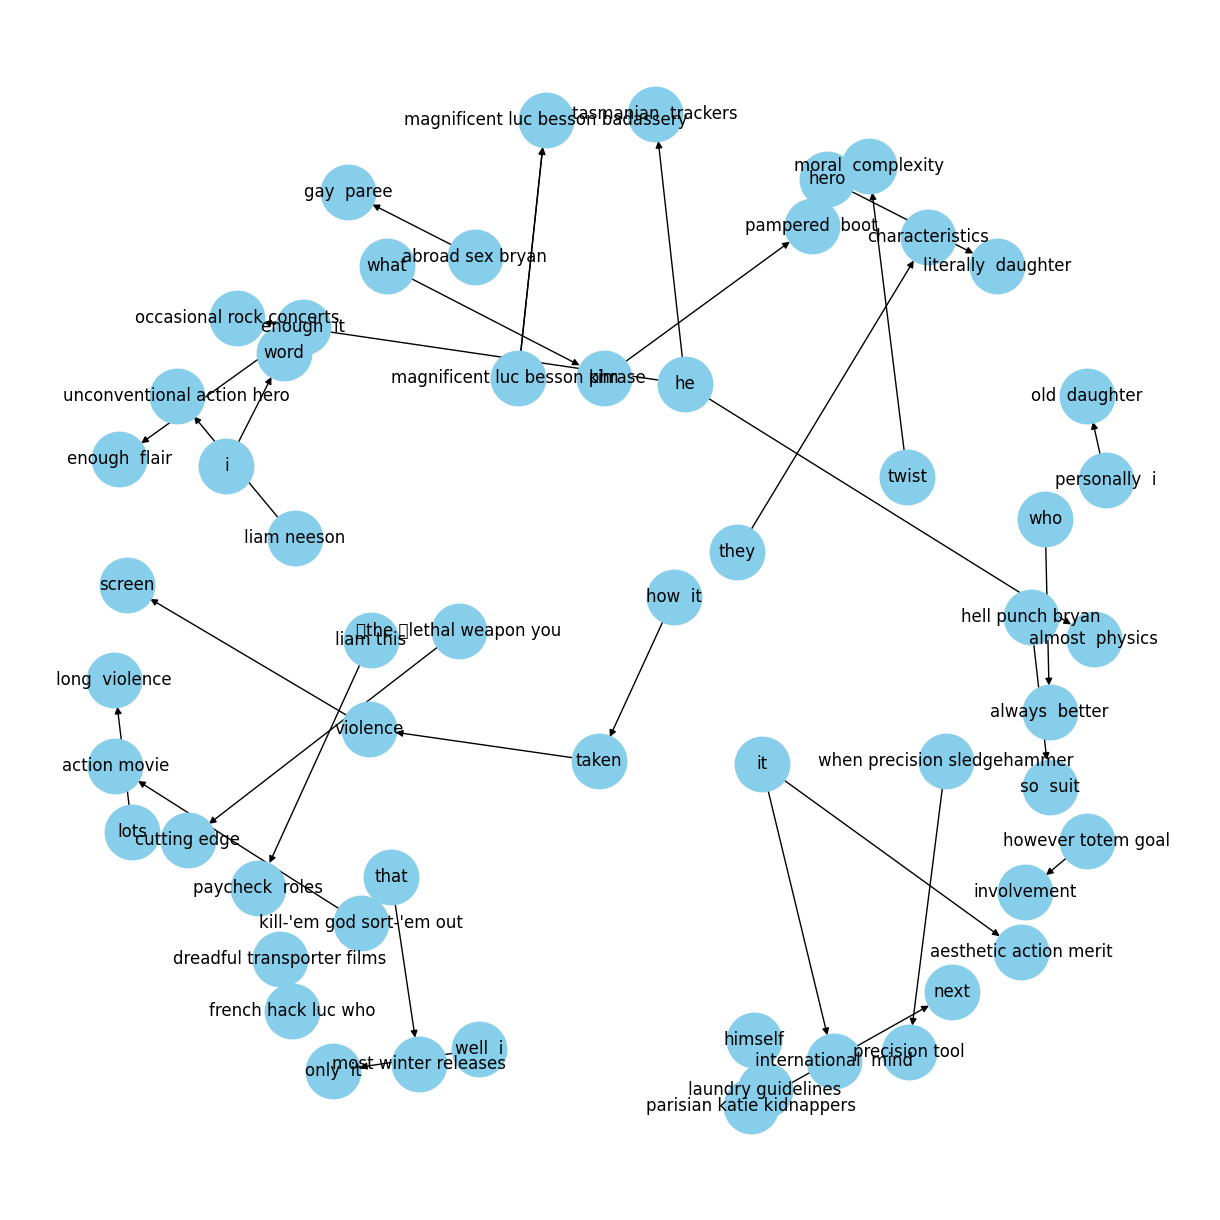

In [16]:
RELATION_TO_EXPLORE = 'is'

G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

#### Entities

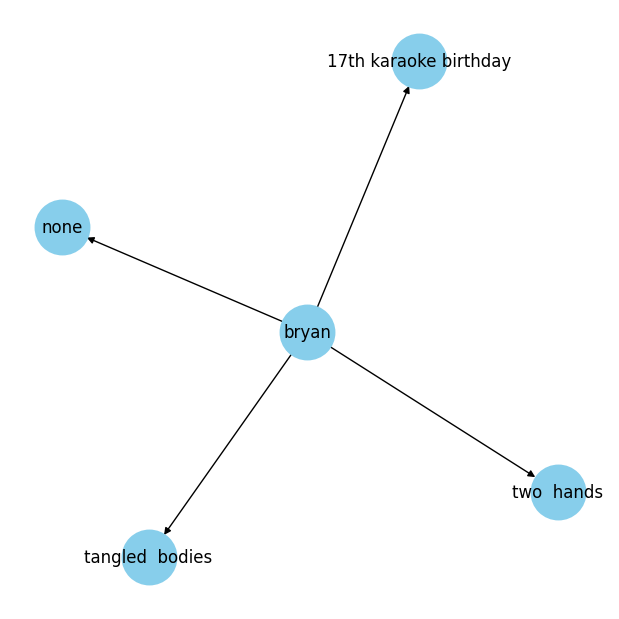

In [17]:
ENTITY_TO_EXPLORE = 'bryan'

entity_filter = (kg_df['source'] == ENTITY_TO_EXPLORE) | (kg_df['target'] == ENTITY_TO_EXPLORE)

G = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(6, 6))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

#### Part 1B - Preprocessed Text

In [18]:
class_corpus.loc[:,'Processed Text'] = class_corpus.loc[:,'Lemmatized'].apply(lambda x: ' '.join(x))

In [19]:
movie_reviews = (class_corpus.loc[class_corpus['Movie Title'] == MOVIE_TO_EXPLORE, 'Processed Text']
                             .reset_index(drop=True))

In [20]:
# Assuming you have your 'equivalent_classes' dictionary defined
equivalent_classes = {
    'liam neeson':'liam',
    'neeson':'liam',
    'father':'liam',
    'maggie grace':'maggie',
    'daughter':'maggie',
    'central intelligence agency':'cia',
    'paris france':'paris',
    'paris, france':'paris',
    'united states':'USA',
    'united states of america':'USA',
    'organized crime':'criminal',
    'criminals':'criminal',
    'albanians':'criminal',
    'luc besson':'luc',
    'writer':'luc',
    'writers':'luc',
    'pierre morel':'pierre',
    'morel':'pierre',
    'director':'pierre',
    'directors':'pierre',
    'kidnapping':'kidnap',
    'kidnapped':'kidnap',
    'abduct':'kidnap',
    'abducting':'kidnap',
    'abducted':'kidnap'
    # ... your equivalent classes mapping here
}

In [21]:
# Your normalization function
def normalize_entity(entity):
    return equivalent_classes.get(entity.lower(), entity)

100%|██████████| 31/31 [00:00<00:00, 134.52it/s]
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 148 (\x94) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print

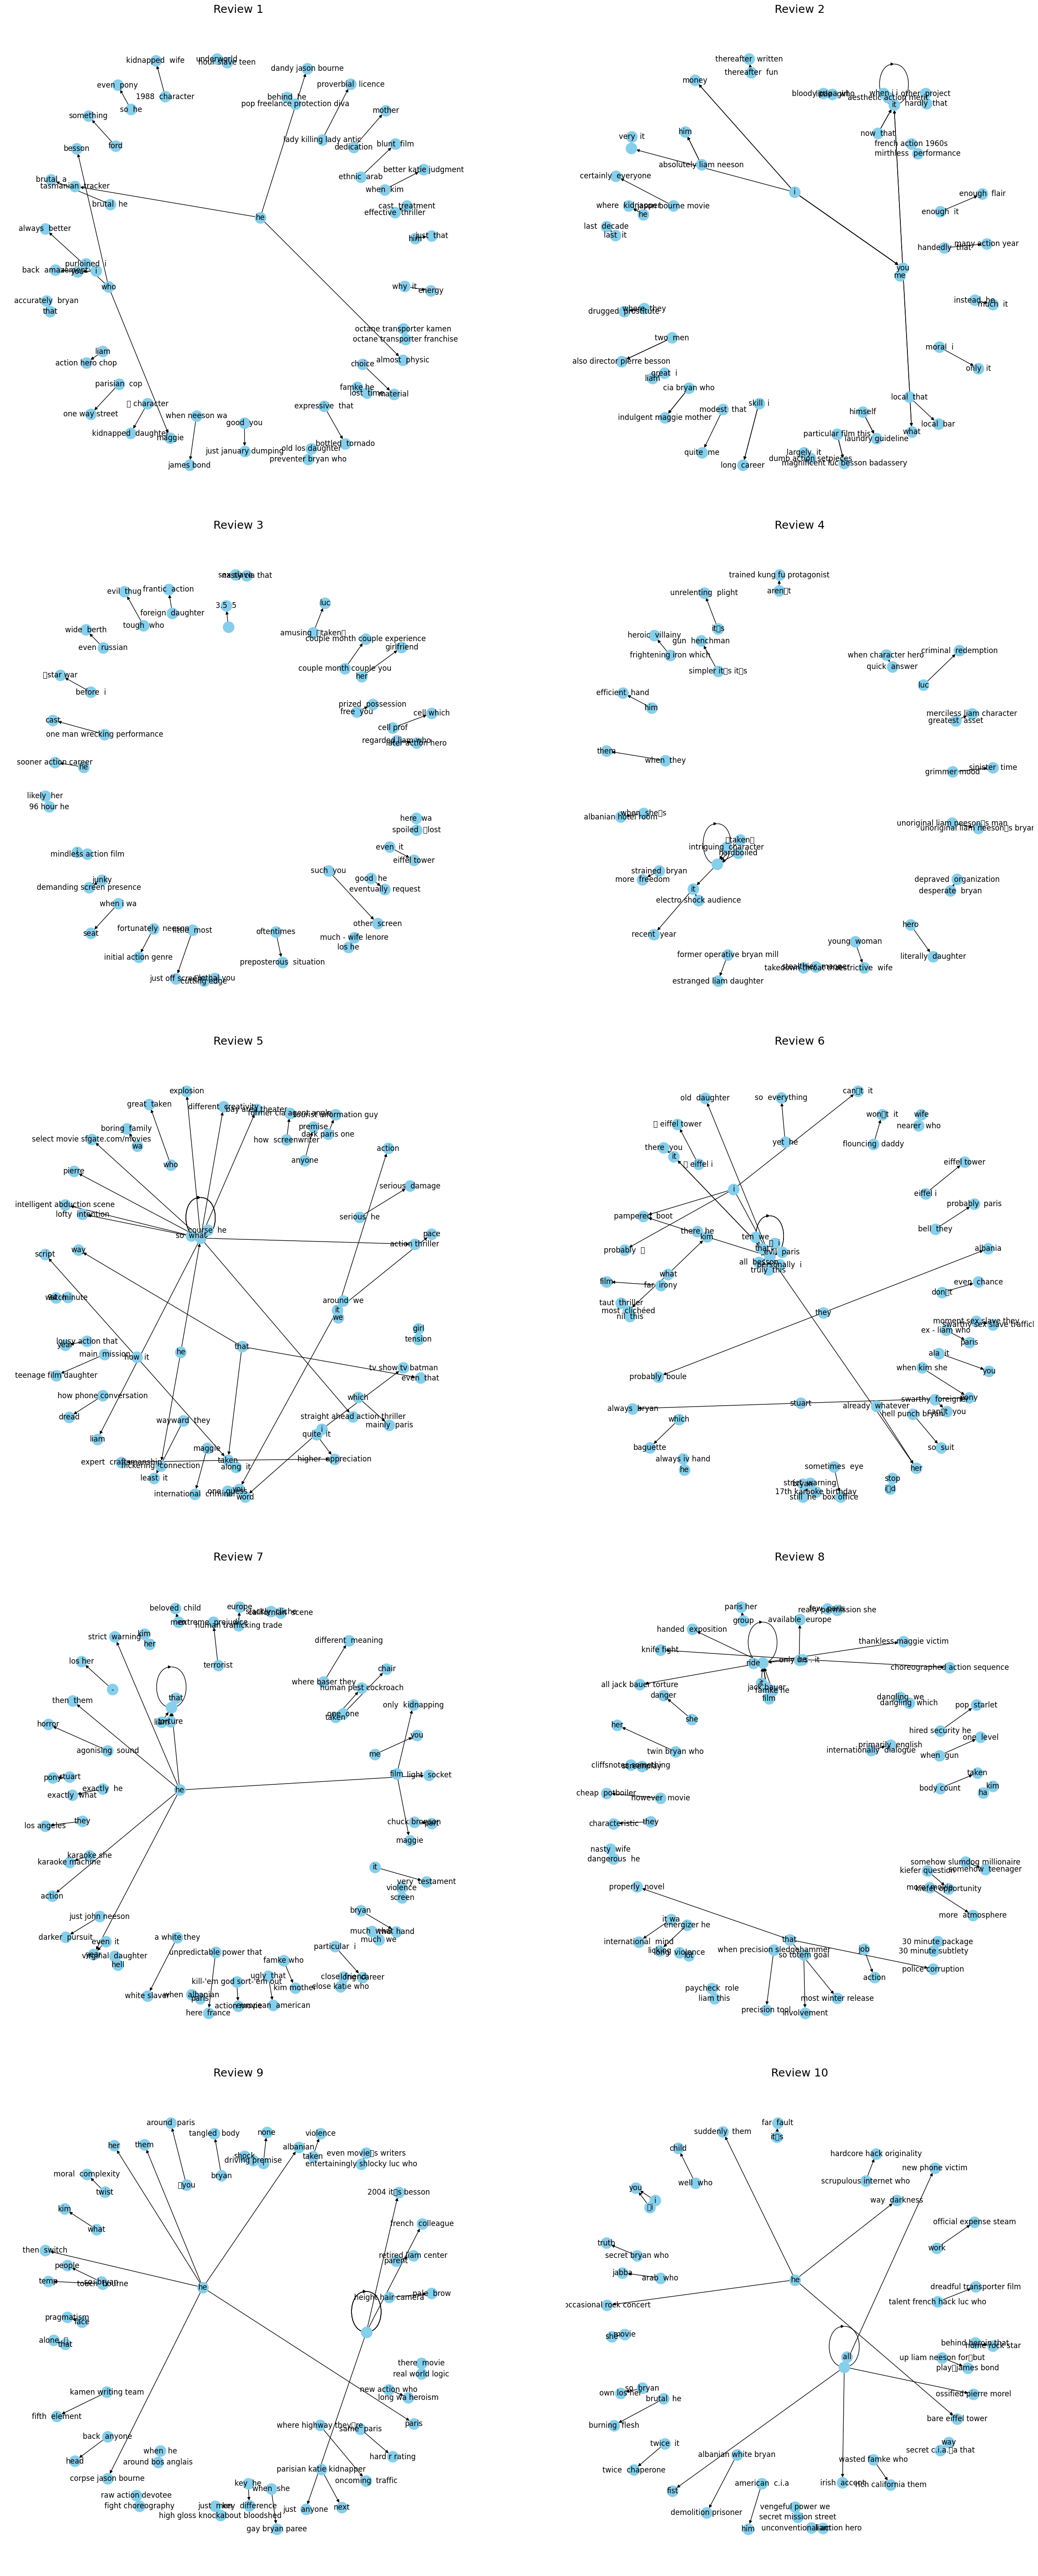

In [22]:


# Prepare the figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(30, 15 * 5))  # Adjust the size as needed
fig.subplots_adjust(hspace=0.05, wspace=0.2)

for i in range(10):
    doc = nlp(movie_reviews[i])
    doc_sents = [str(x) for x in list(doc.sents)]
    entity_pairs = []

    for sent in tqdm(doc_sents):
        # Extract entities using your existing function
        entities = get_entities(sent)
        # Normalize entities to their canonical form
        normalized_entities = [normalize_entity(e) for e in entities]
        entity_pairs.append(normalized_entities)

    # Continue with relation extraction and knowledge graph creation
    relations = [get_relation(sent) for sent in tqdm(doc_sents)]
    source = [x[0] for x in entity_pairs]
    target = [x[1] for x in entity_pairs]
    kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

    # Create a directed-graph from a dataframe
    G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

    # Choose the current subplot
    ax = axes[i // 2, i % 2]
    plt.sca(ax)

    pos = nx.spring_layout(G, seed=42)  # Using a fixed seed for consistent layout
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos, ax=ax)

    # Set the title for the current graph
    ax.set_title(f'Review {i + 1}')

# Show the plot
plt.show()


100%|██████████| 392/392 [00:02<00:00, 157.28it/s]


NetworkXError: draw_networkx_edge_labels does not support multiedges.

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 150 (\x96) missing from current font.
  func(*args, **kwargs)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 147 (\x93) missing from current font.
  func(*args, **kwargs)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 148 (\x94) missing from current font.
  func(*args, **kwargs)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 146 (\x92) missing from current font.
  func(*args, **kwargs)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from c

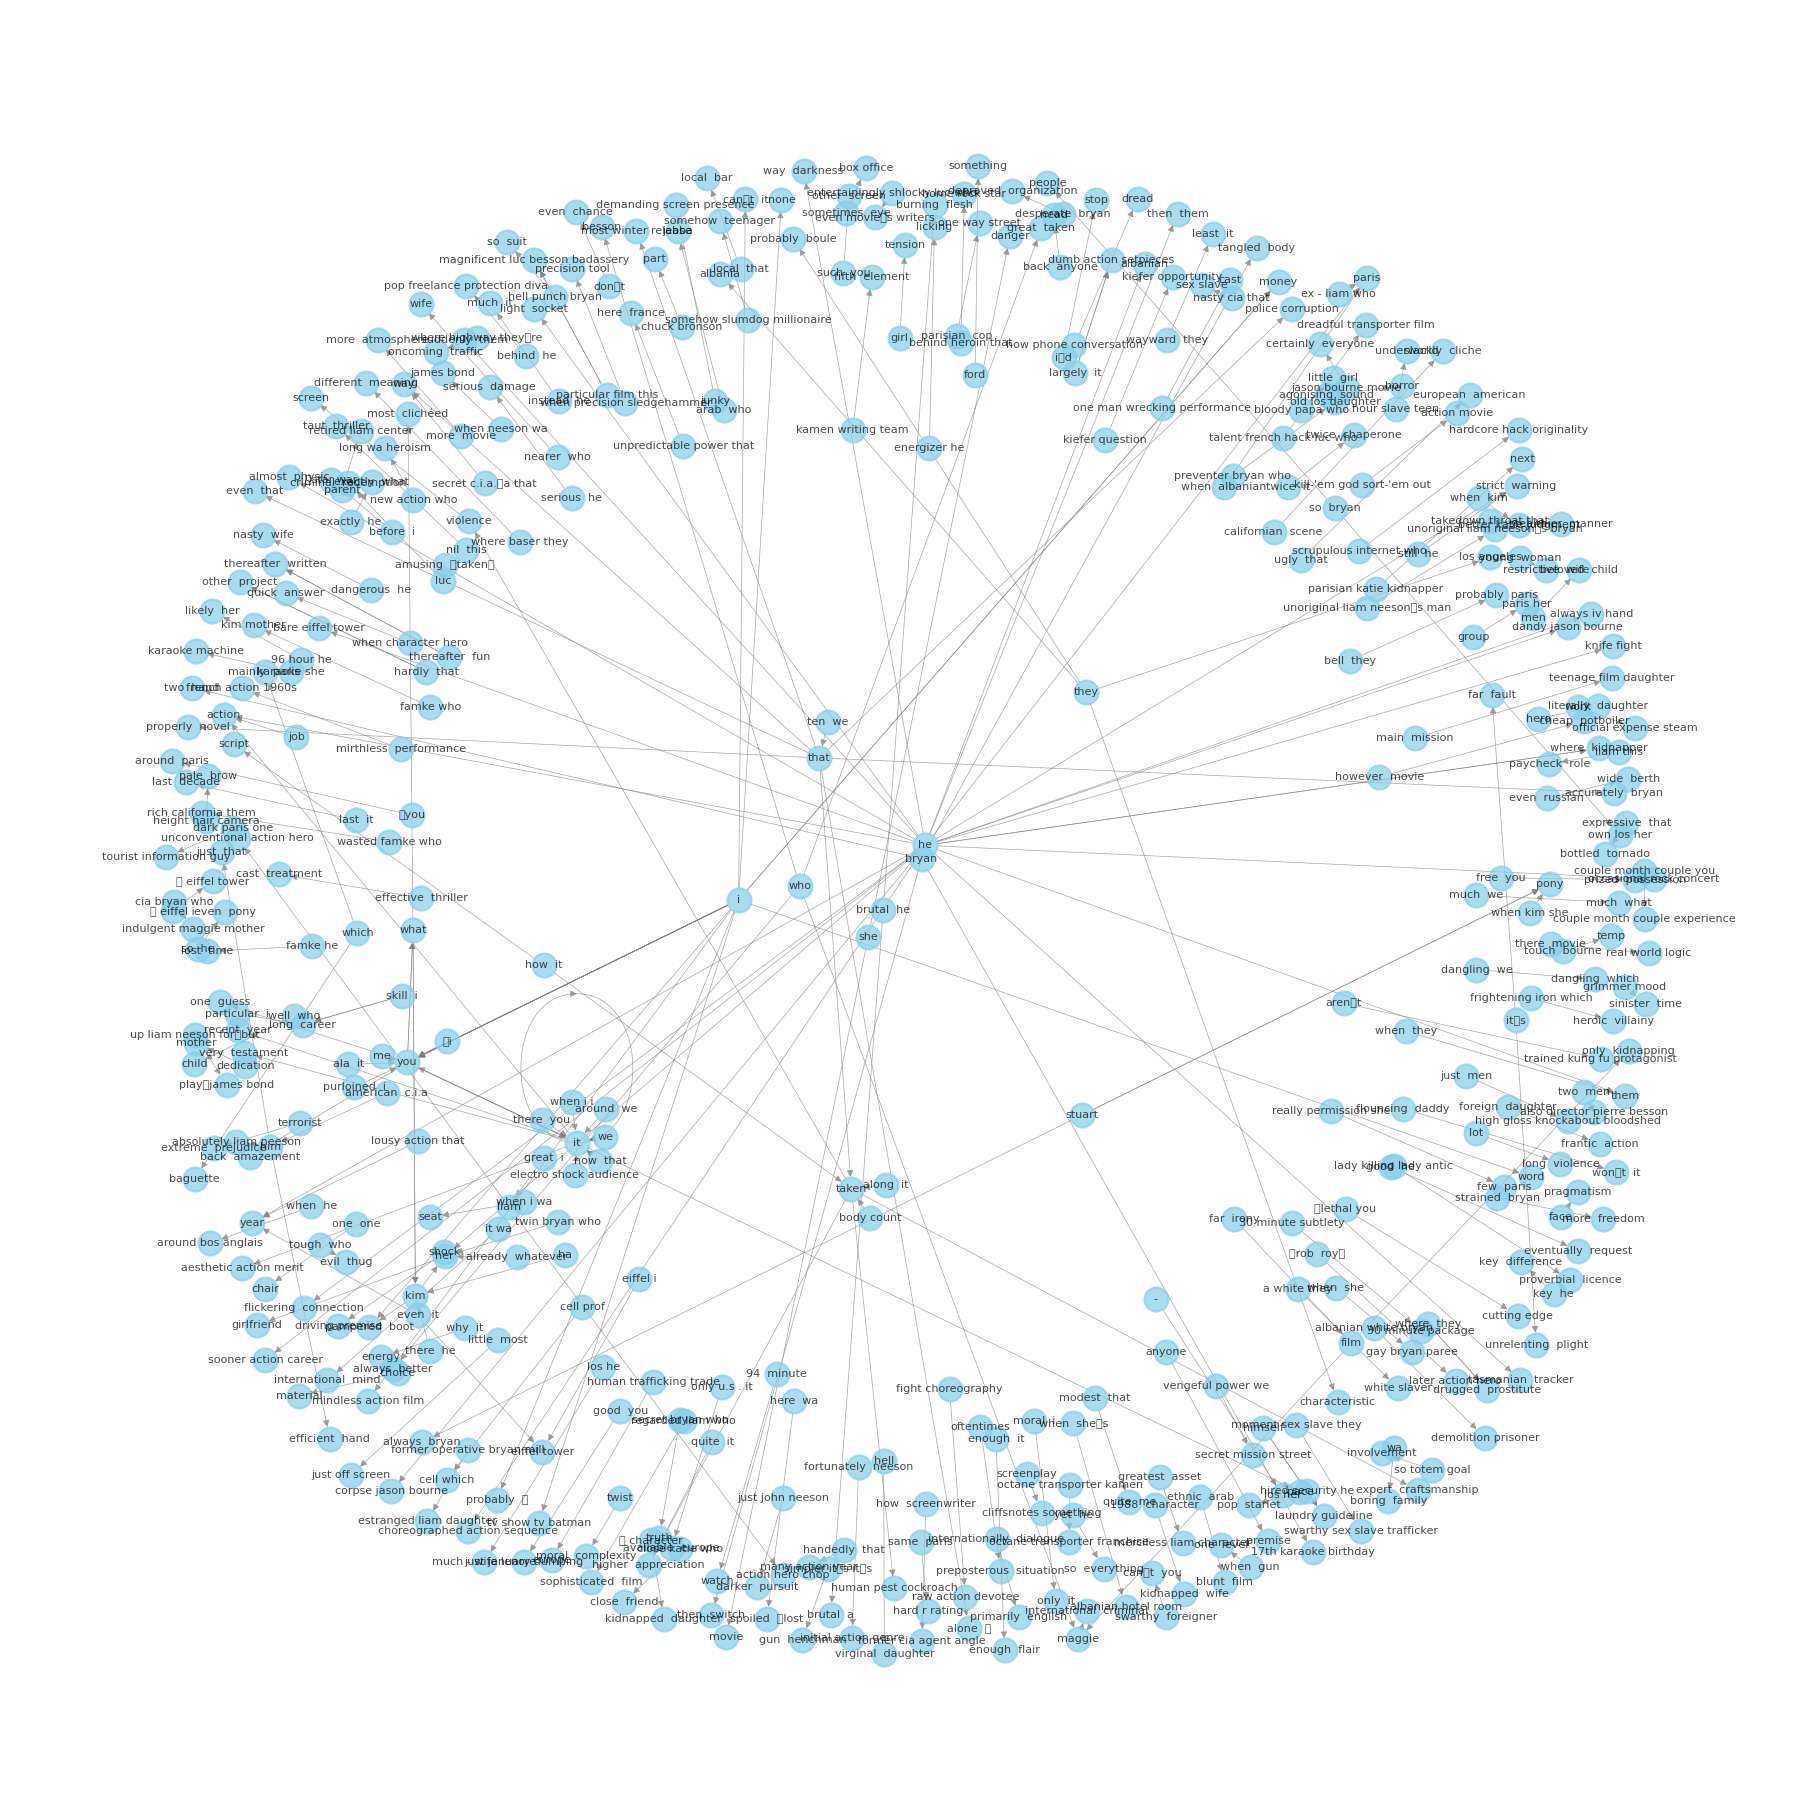

In [23]:
# Now let's incorporate the normalization into the existing process
all_movie_reviews = ' '.join(movie_reviews)

doc = nlp(all_movie_reviews)

doc_sents = [str(x) for x in doc.sents]

entity_pairs = []

for i in tqdm(doc_sents):
    entities = get_entities(i)
    normalized_entities = [normalize_entity(ent) for ent in entities]  # Normalize the entities here
    entity_pairs.append(normalized_entities)

relations = [get_relation(i) for i in tqdm(doc_sents)]

# Extract and normalize subject and object
source = [normalize_entity(i[0]) for i in entity_pairs]
target = [normalize_entity(i[1]) for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empty strings
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(18,18))  # Adjust the figure size as needed

# Define node positions using a layout of your choice
pos = nx.spring_layout(G, k=0.1)  # 'k' regulates the distance between nodes

# Draw the graph with the normalized entities and adjusted node and font sizes
nx.draw(G, pos,
        with_labels=True,
        node_color='skyblue',
        node_size=300,
        font_size=8,
        width=0.5,
        edge_color='gray',
        arrowsize=10,
        alpha=0.7)

# Optional: Label edges if required (might clutter the graph if there are many edges)
edge_labels = nx.get_edge_attributes(G, 'edge')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.axis('off')
plt.show()


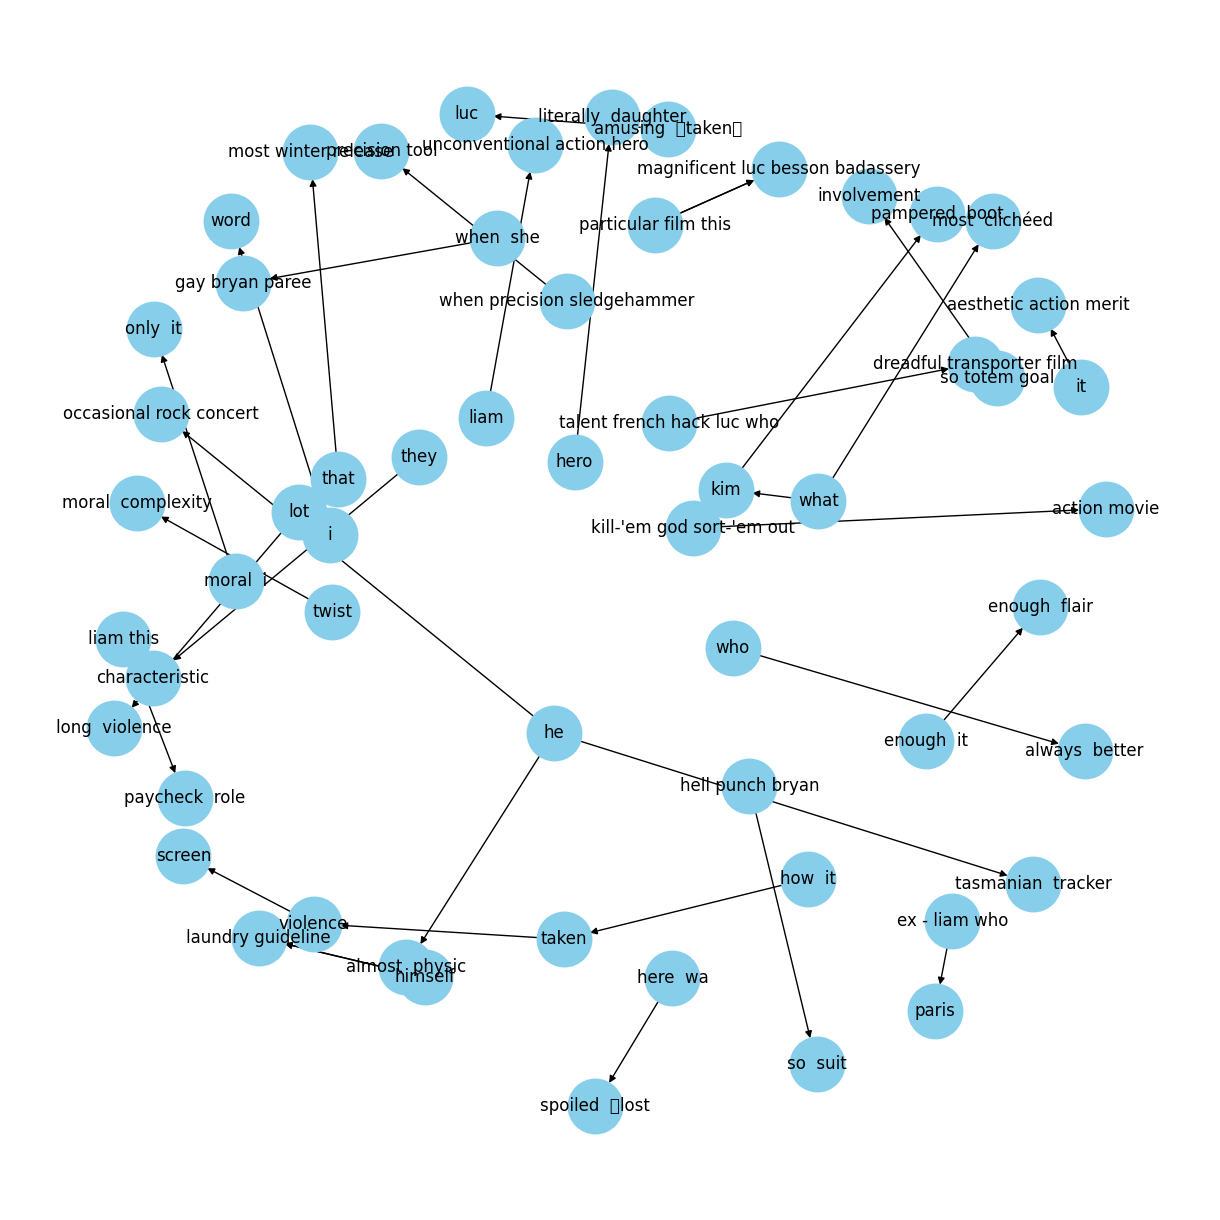

In [24]:

# Normalize the 'source' and 'target' columns in the DataFrame
kg_df['source'] = kg_df['source'].apply(normalize_entity)
kg_df['target'] = kg_df['target'].apply(normalize_entity)

RELATION_TO_EXPLORE = 'is'

# Filter the DataFrame to include only rows where the 'edge' column matches RELATION_TO_EXPLORE
filtered_kg_df = kg_df[kg_df['edge'].str.lower() == RELATION_TO_EXPLORE.lower()]

# Create a directed graph from the filtered DataFrame
G = nx.from_pandas_edgelist(filtered_kg_df, 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

# Define the layout for the nodes
pos = nx.spring_layout(G, k=0.5)  # 'k' regulates the distance between nodes

# Draw the graph
nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()


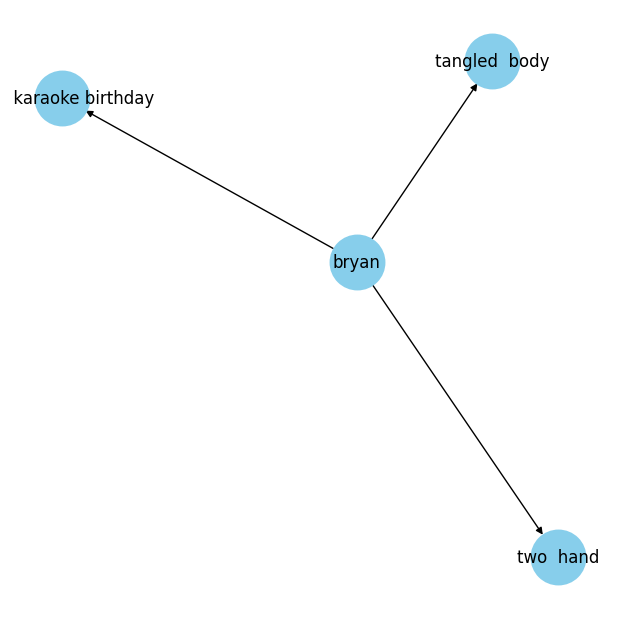

In [25]:
ENTITY_TO_EXPLORE = 'bryan'

entity_filter = (kg_df['source'] == ENTITY_TO_EXPLORE) | (kg_df['target'] == ENTITY_TO_EXPLORE)

G = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(6, 6))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

#### Part 2: Deep Learning

#### Functions

In [33]:
class_corpus.loc[:,'Processed Text'] = class_corpus.loc[:,'Text'].apply(lambda x: ' '.join(x))

In [123]:
def evaluate_models(true_labels, *model_predictions):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    evaluation_results = []
    
    for predictions in model_predictions:
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
        
        evaluation_results.append([accuracy, precision, recall, f1])
        
    evaluation_df = pd.DataFrame(evaluation_results, columns=metrics)
    
    return round(evaluation_df,4)


def plot_confusion_matrices(y_true,n, *model_predictions):

    fig, axes = plt.subplots(2, 2, figsize=(18,15))
    axes = axes.flatten()

    for i, predictions in enumerate(model_predictions):
        cm = confusion_matrix(y_true, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f"Model {i + n} Confusion Matrix")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")
    
    plt.tight_layout()
    plt.show()

#### Part 2A: Multi-Class Classification (Genre)

2/2 [==============================] - 1s 12ms/step


Model  Accuracy  Precision  Recall  F1 Score
0    One     0.200     0.3064   0.200    0.0991
1    Two     0.250     0.1557   0.250    0.1432
2  Three     0.325     0.1636   0.325    0.2150
3   Four     0.200     0.0400   0.200    0.0667

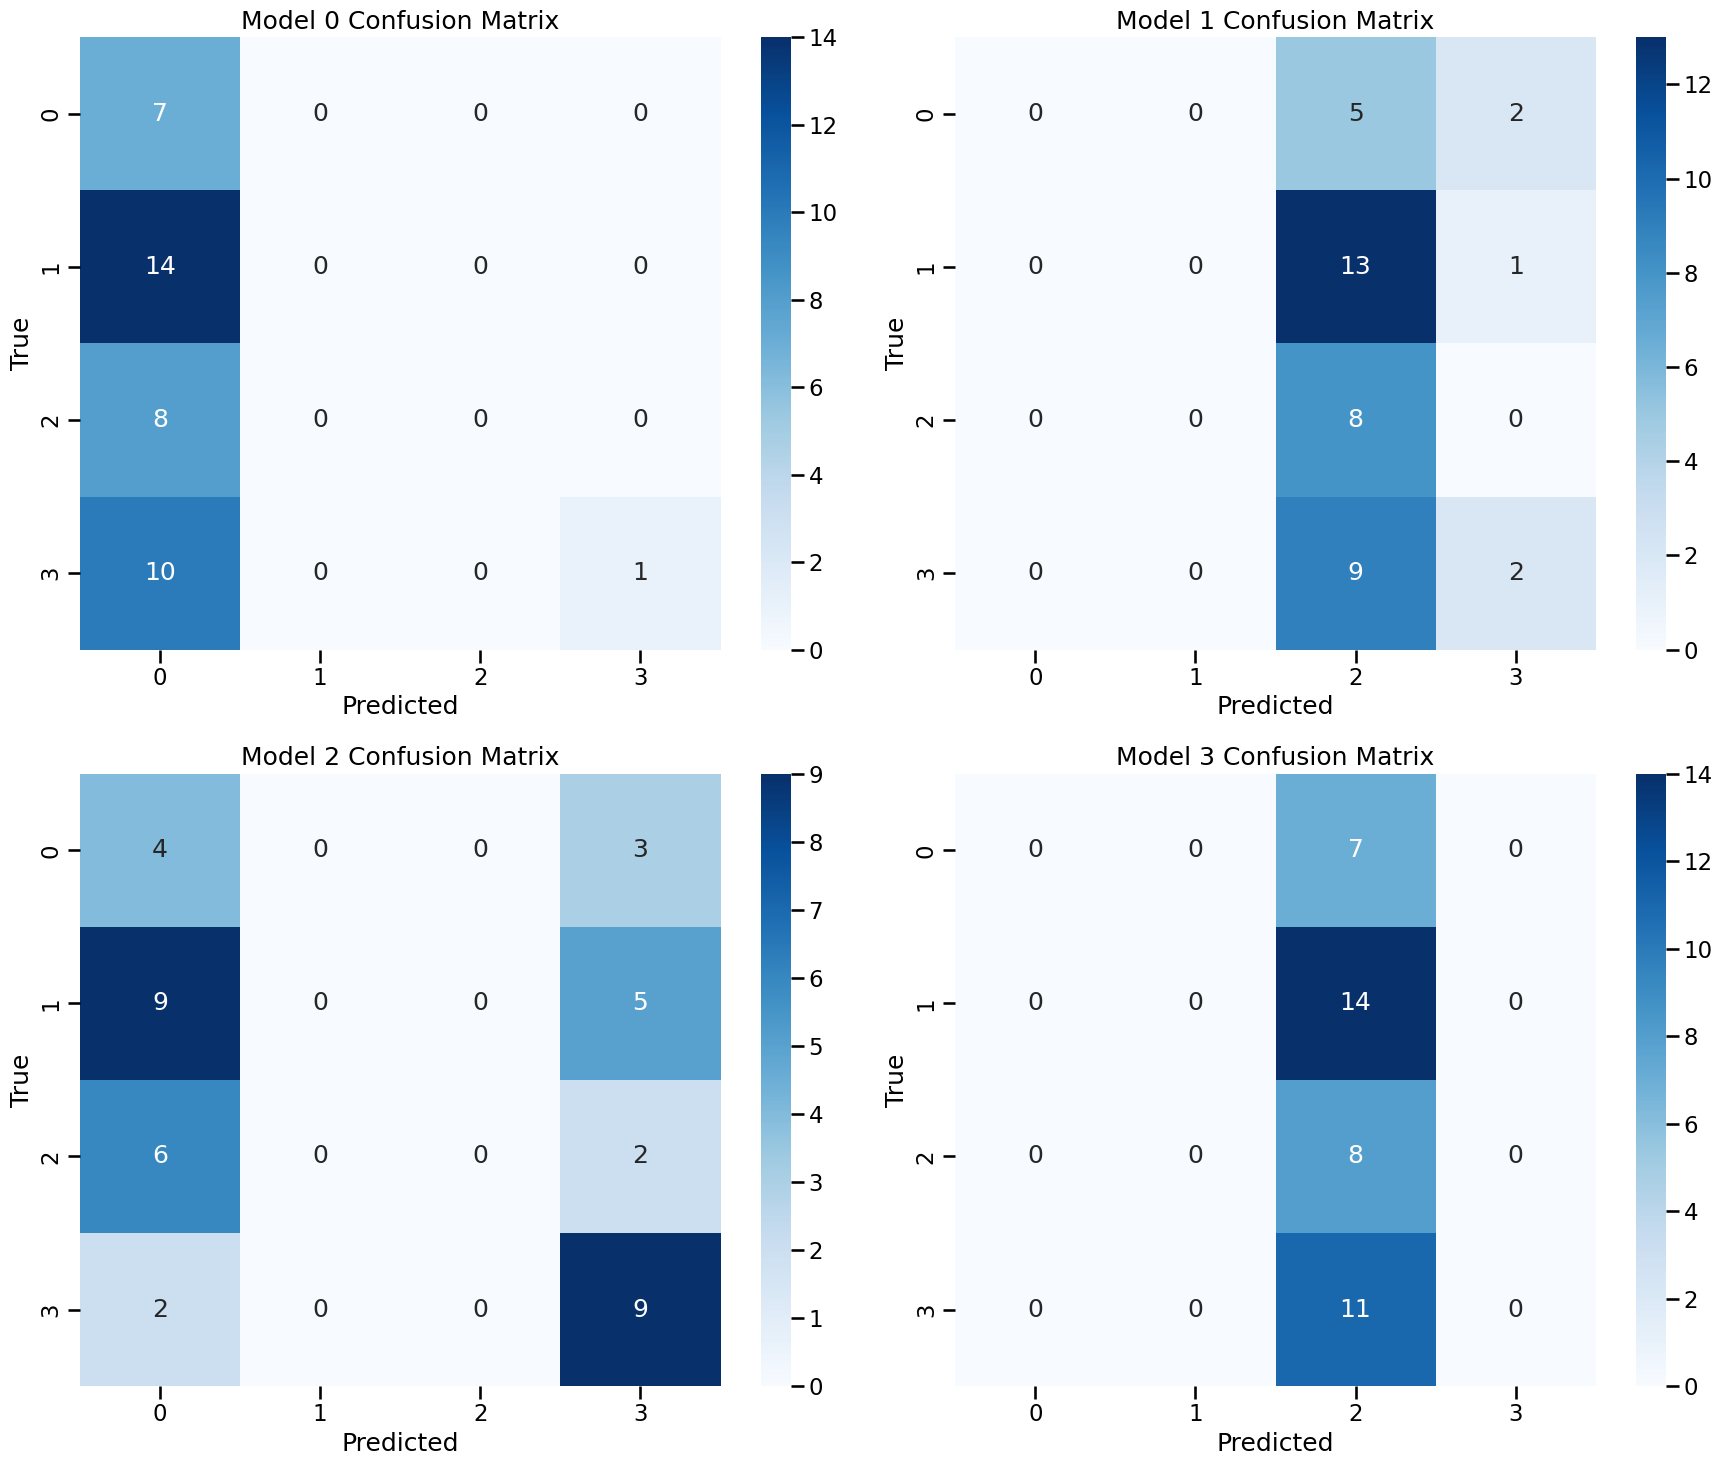

None

In [139]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(class_corpus['Processed Text'])]
doc2vec_model = Doc2Vec(tagged_data, vector_size=50, window=2, min_count=1, workers=4)
doc_vectors = [doc2vec_model.infer_vector(doc.words) for doc in tagged_data]

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(class_corpus['Genre'])
labels = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(doc_vectors, labels, test_size=0.2, random_state=42)
X_train = np.array(X_train).reshape((len(X_train), 50, 1))  # Reshape for LSTM
X_test = np.array(X_test).reshape((len(X_test), 50, 1))

model_one = Sequential()
model_one.add(LSTM(264, input_shape=(50, 1))) 
model_one.add(Dense(4, activation='softmax'))
model_one.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_one = model_one.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_one = model_one.predict(X_test)
pred_one = argmax(pred_one, axis=1)

model_two = Sequential()
model_two.add(Bidirectional(LSTM(128), input_shape=(50, 1)))  
model_two.add(Dense(4, activation='softmax'))  
model_two.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_two = model_two.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_two = model_two.predict(X_test)
pred_two = argmax(pred_two, axis=1)

model_three = Sequential()
model_three.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(50, 1)))
model_three.add(Bidirectional(LSTM(128)))
model_three.add(Dense(4, activation='softmax'))
model_three.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_three = model_three.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_three = model_three.predict(X_test)
pred_three = argmax(pred_three, axis=1)

model_four = Sequential()
model_four.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(50, 1)))
model_four.add(Dropout(0.5))
model_four.add(Bidirectional(LSTM(128)))
model_four.add(Dropout(0.5))
model_four.add(Dense(4, activation='softmax'))
model_four.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_four = model_four.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_four = model_four.predict(X_test)
pred_four = argmax(pred_four, axis=1)

y_test_labels = argmax(y_test, axis=1)

doc2vec_results = evaluate_models(y_test_labels,pred_one,pred_two,pred_three,pred_four)
doc2vec_results['Model'] = ['One','Two','Three','Four']
display(doc2vec_results.iloc[:,[-1,0,1,2,3]])

display(plot_confusion_matrices(y_test_labels,0,pred_one,pred_two,pred_three,pred_four))

2/2 [==============================] - 0s 1ms/step


Model  Accuracy  Precision  Recall  F1 Score
0   Five       1.0        1.0     1.0       1.0
1    Six       1.0        1.0     1.0       1.0
2  Seven       1.0        1.0     1.0       1.0
3  Eight       1.0        1.0     1.0       1.0

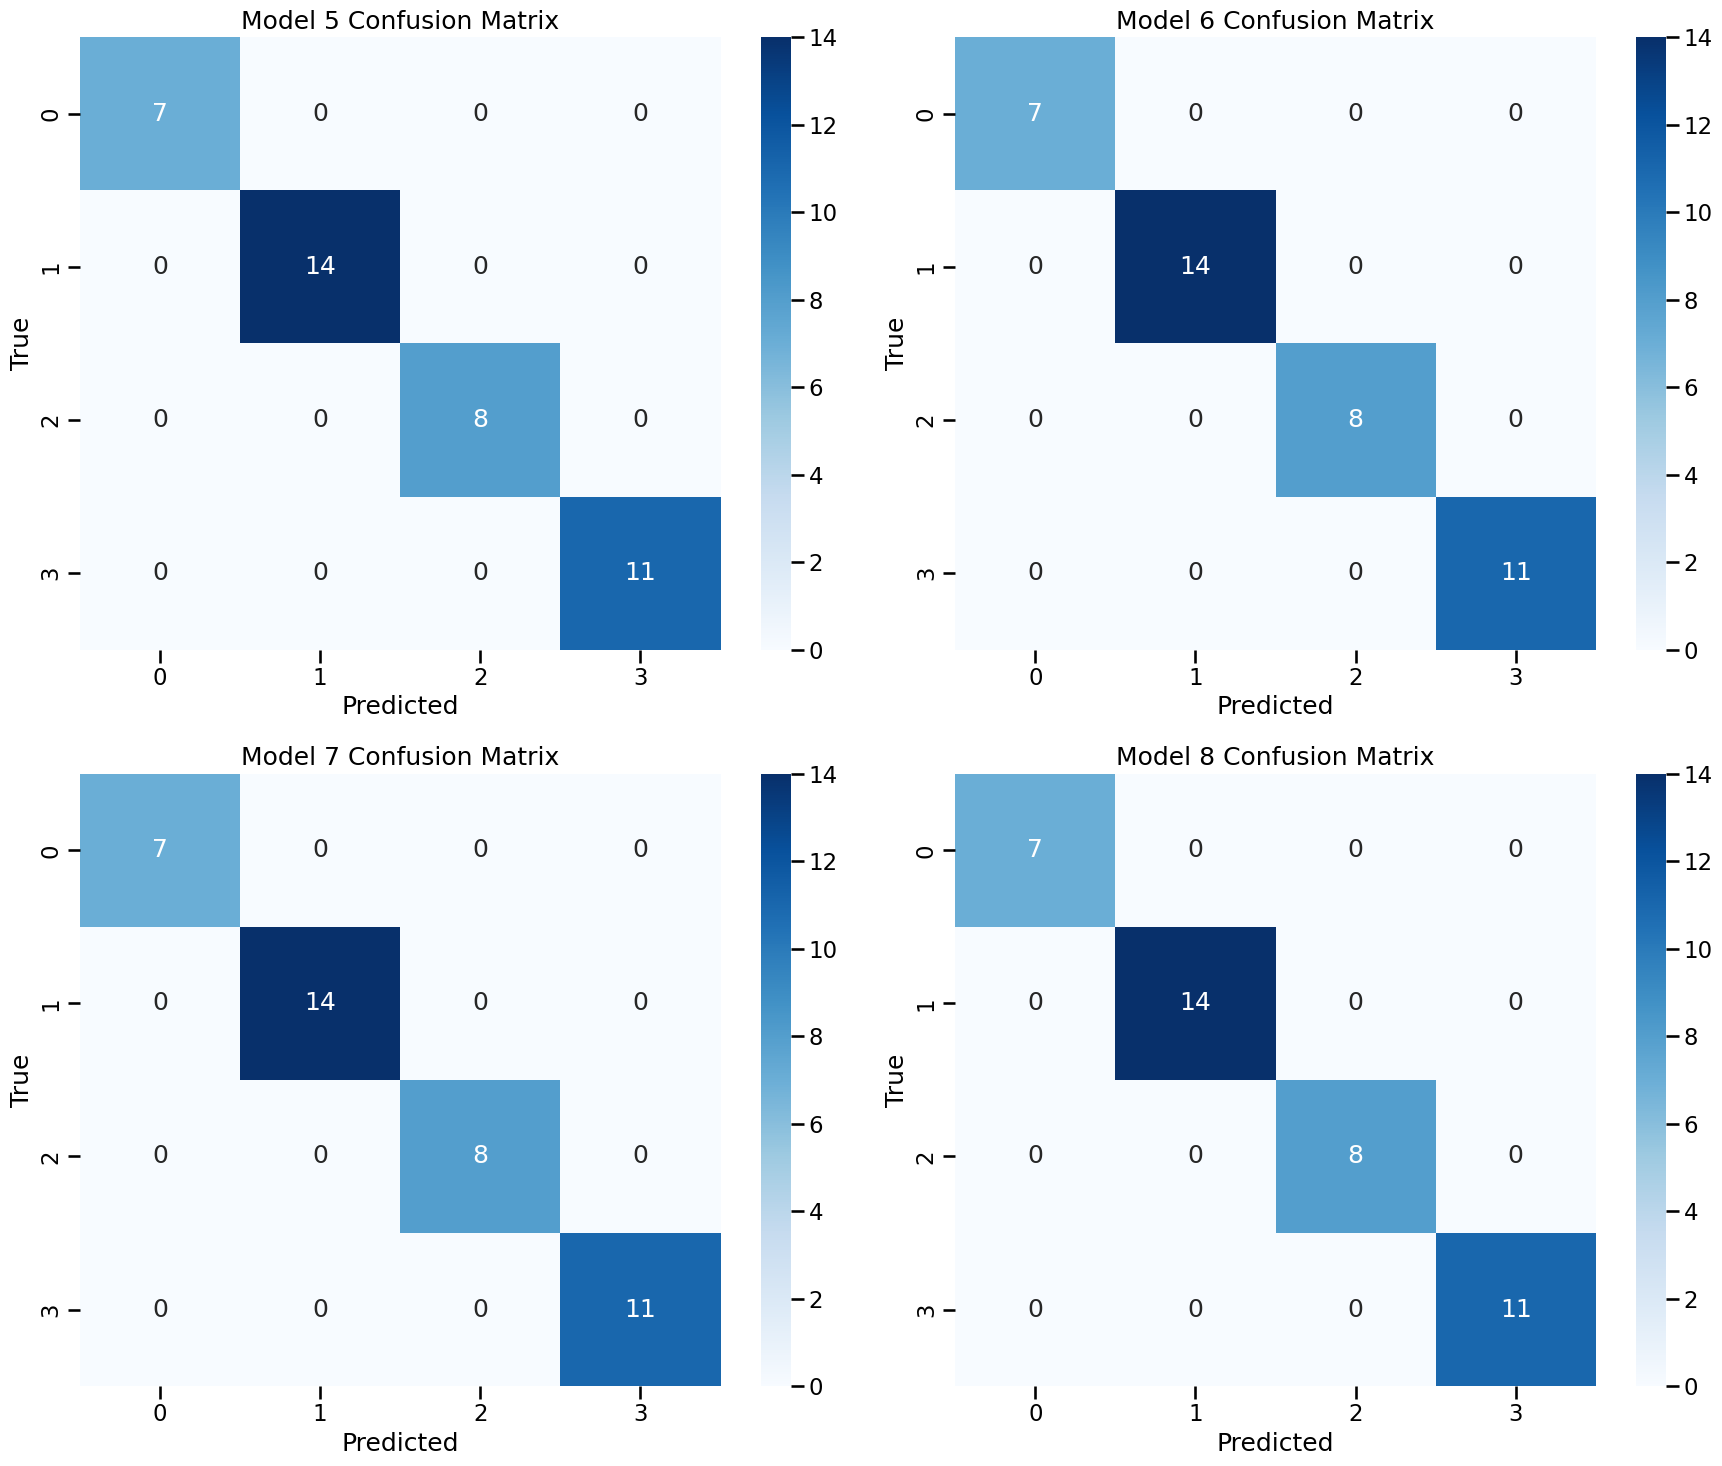

None

In [140]:
# Vectorizing text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Adjust the number of features as needed
tfidf_vectors = tfidf.fit_transform(class_corpus['Processed Text']).toarray()

# Encoding genres
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(class_corpus['Genre'])
labels = to_categorical(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, labels, test_size=0.2, random_state=42)

# Define the models - Adjust input_dim to match the number of features from TF-IDF
input_dim = X_train.shape[1]  # Number of features

model_five = Sequential()
model_five.add(Dense(264, input_dim=input_dim, activation='relu')) 
model_five.add(Dense(4, activation='softmax'))
model_five.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_five = model_five.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_five = model_five.predict(X_test)
pred_five = np.argmax(pred_five, axis=1)

# Model Six: A single dense layer with more units
model_six = Sequential()
model_six.add(Dense(512, input_dim=input_dim, activation='relu'))  # More units
model_six.add(Dense(4, activation='softmax'))
model_six.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_six = model_six.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_six = model_six.predict(X_test)
pred_six = np.argmax(pred_six, axis=1)

# Model Seven: Two dense layers
model_seven = Sequential()
model_seven.add(Dense(256, input_dim=input_dim, activation='relu'))  # First dense layer
model_seven.add(Dense(128, activation='relu'))  # Second dense layer
model_seven.add(Dense(4, activation='softmax'))
model_seven.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_seven = model_seven.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_seven = model_seven.predict(X_test)
pred_seven = np.argmax(pred_seven, axis=1)

# Model Eight: Two dense layers with dropout
model_eight = Sequential()
model_eight.add(Dense(256, input_dim=input_dim, activation='relu'))  # First dense layer
model_eight.add(Dropout(0.5))  # Dropout layer
model_eight.add(Dense(128, activation='relu'))  # Second dense layer
model_eight.add(Dropout(0.5))  # Another dropout layer
model_eight.add(Dense(4, activation='softmax'))
model_eight.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_eight = model_eight.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_eight = model_eight.predict(X_test)
pred_eight = np.argmax(pred_eight, axis=1)

tfidf_results = evaluate_models(y_test_labels,pred_five,pred_six,pred_seven,pred_eight)
tfidf_results['Model'] = ['Five','Six','Seven','Eight']
display(tfidf_results.iloc[:,[-1,0,1,2,3]])

display(plot_confusion_matrices(y_test_labels,5,pred_five,pred_six,pred_seven,pred_eight))

#### Part 2B: Binary Classification (Sentiment Analysis)

2/2 [==============================] - 1s 13ms/step


Model  Accuracy  Precision  Recall  F1 Score
0    Nine      0.45     0.2025    0.45    0.2793
1     Ten      0.55     0.5688    0.55    0.5466
2  Eleven      0.45     0.2025    0.45    0.2793
3  Twelve      0.45     0.2025    0.45    0.2793

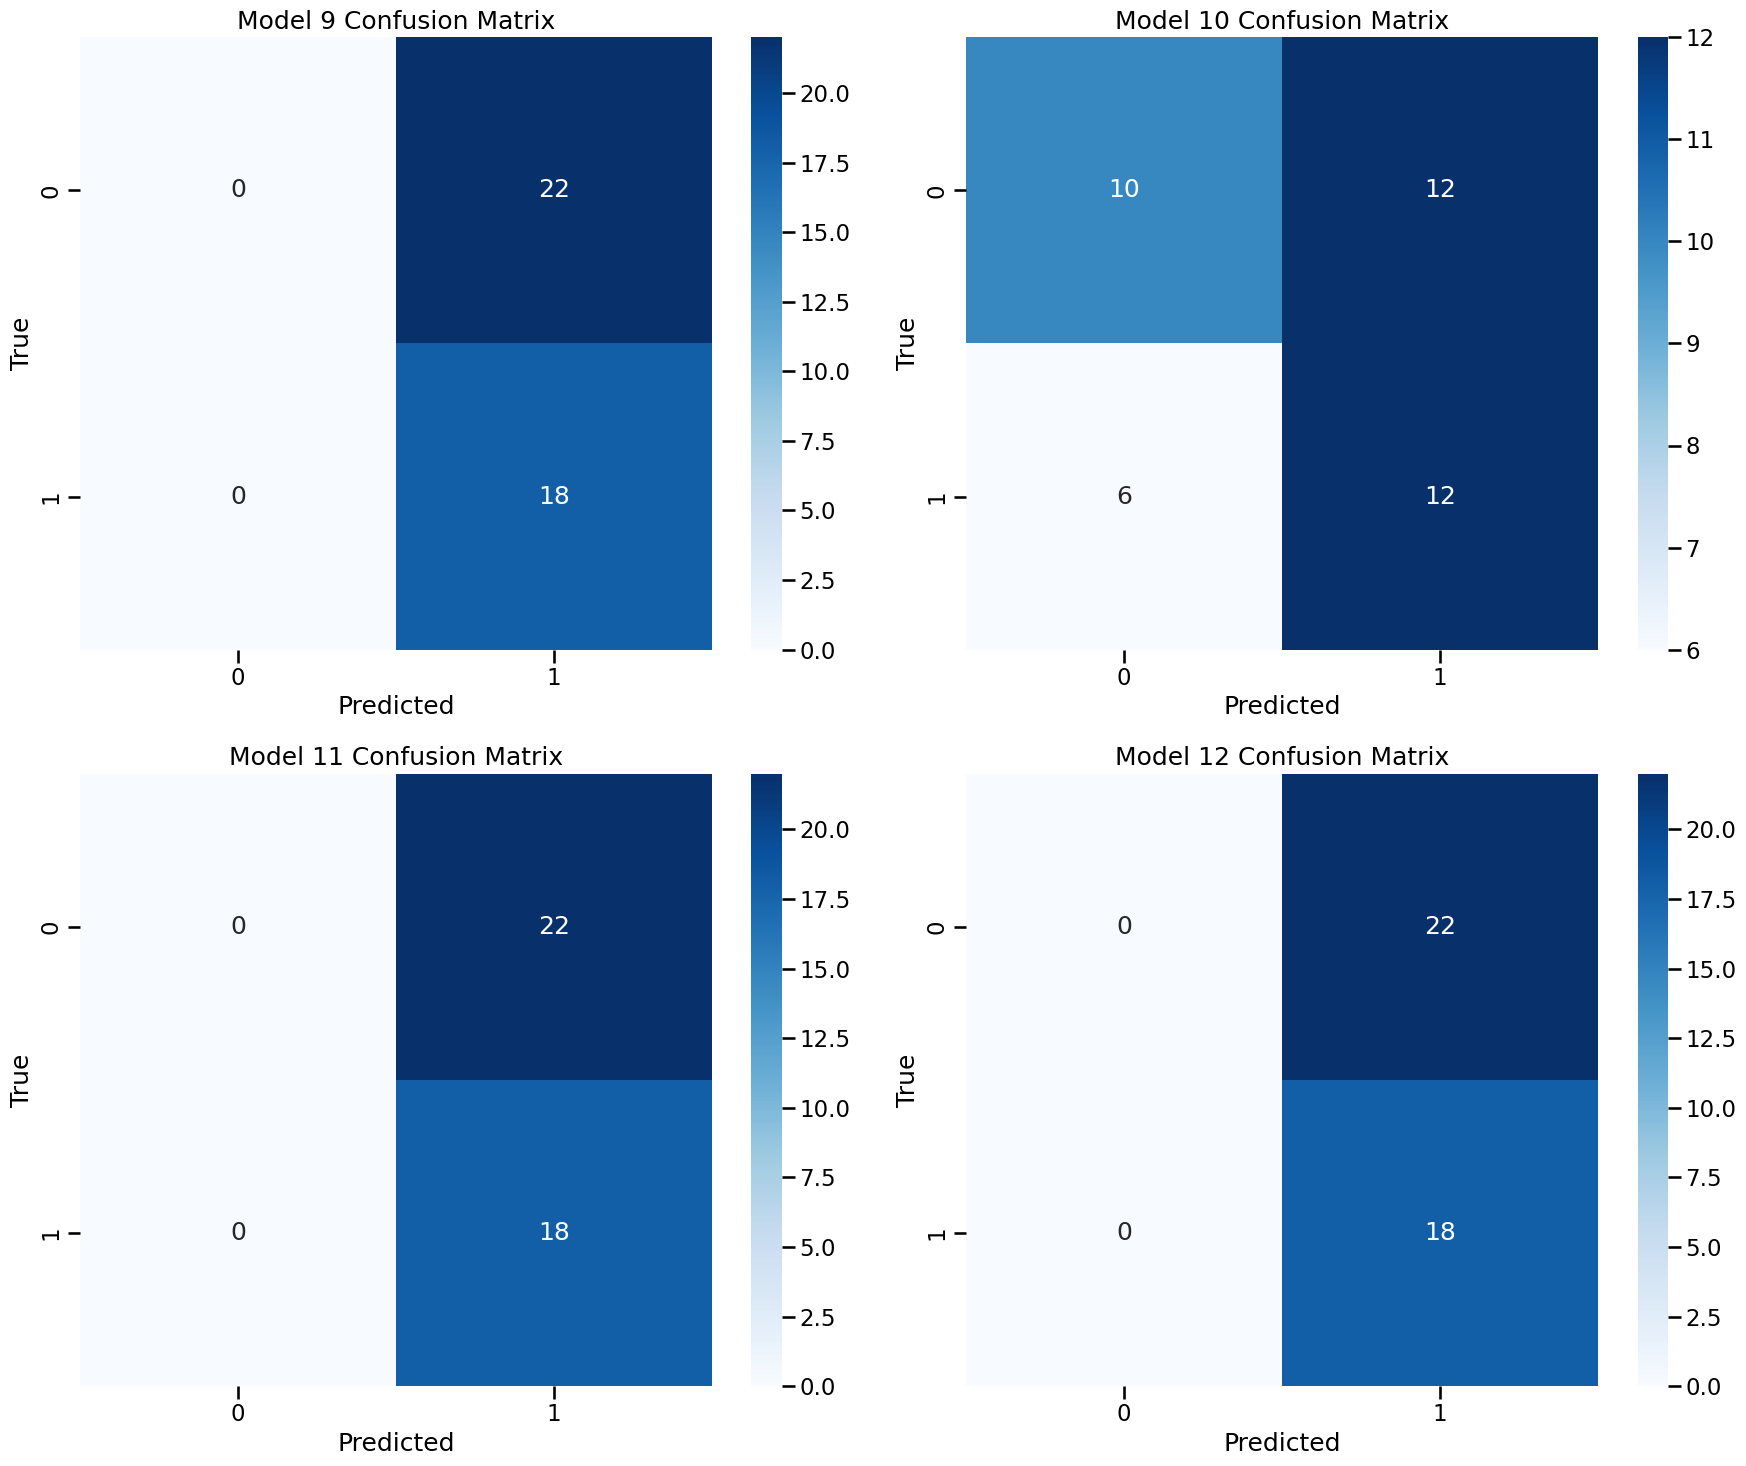

None

In [142]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(class_corpus['Processed Text'])]
doc2vec_model = Doc2Vec(tagged_data, vector_size=50, window=2, min_count=1, workers=4)
doc_vectors = [doc2vec_model.infer_vector(doc.words) for doc in tagged_data]

# Changed to use 'Sentiment' instead of 'Genre'
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(class_corpus['Sentiment'])
labels = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(doc_vectors, labels, test_size=0.2, random_state=42)
X_train = np.array(X_train).reshape((len(X_train), 50, 1))  # Reshape for LSTM
X_test = np.array(X_test).reshape((len(X_test), 50, 1))

# Model Nine
model_nine = Sequential()
model_nine.add(LSTM(264, input_shape=(50, 1))) 
model_nine.add(Dense(labels.shape[1], activation='softmax'))  # Adjusted the output layer to match the number of sentiment labels
model_nine.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_nine = model_nine.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_nine = model_nine.predict(X_test)
pred_nine = argmax(pred_nine, axis=1)

# Model Ten
model_ten = Sequential()
model_ten.add(Bidirectional(LSTM(128), input_shape=(50, 1)))  
model_ten.add(Dense(labels.shape[1], activation='softmax'))  # Adjusted the output layer
model_ten.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_ten = model_ten.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_ten = model_ten.predict(X_test)
pred_ten = argmax(pred_ten, axis=1)

# Model Eleven
model_eleven = Sequential()
model_eleven.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(50, 1)))
model_eleven.add(Bidirectional(LSTM(128)))
model_eleven.add(Dense(labels.shape[1], activation='softmax'))  # Adjusted the output layer
model_eleven.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_eleven = model_eleven.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_eleven = model_eleven.predict(X_test)
pred_eleven = argmax(pred_eleven, axis=1)

# Model Twelve
model_twelve = Sequential()
model_twelve.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(50, 1)))
model_twelve.add(Dropout(0.5))
model_twelve.add(Bidirectional(LSTM(128)))
model_twelve.add(Dropout(0.5))
model_twelve.add(Dense(labels.shape[1], activation='softmax'))  # Adjusted the output layer
model_twelve.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_twelve = model_twelve.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_twelve = model_twelve.predict(X_test)
pred_twelve = argmax(pred_twelve, axis=1)

y_test_labels = argmax(y_test, axis=1)

# Adjusted to reflect the new model names
doc2vec_results = evaluate_models(y_test_labels, pred_nine, pred_ten, pred_eleven, pred_twelve)
doc2vec_results['Model'] = ['Nine', 'Ten', 'Eleven', 'Twelve']
display(doc2vec_results.iloc[:,[-1,0,1,2,3]])

display(plot_confusion_matrices(y_test_labels, 9, pred_nine, pred_ten, pred_eleven, pred_twelve))

2/2 [==============================] - 0s 1ms/step


Model  Accuracy  Precision  Recall  F1 Score
0  Thirteen     0.425     0.4362   0.425    0.3965
1  Fourteen     0.425     0.4362   0.425    0.3965
2   Fifteen     0.425     0.4372   0.425    0.4086
3   Sixteen     0.400     0.4094   0.400    0.3955

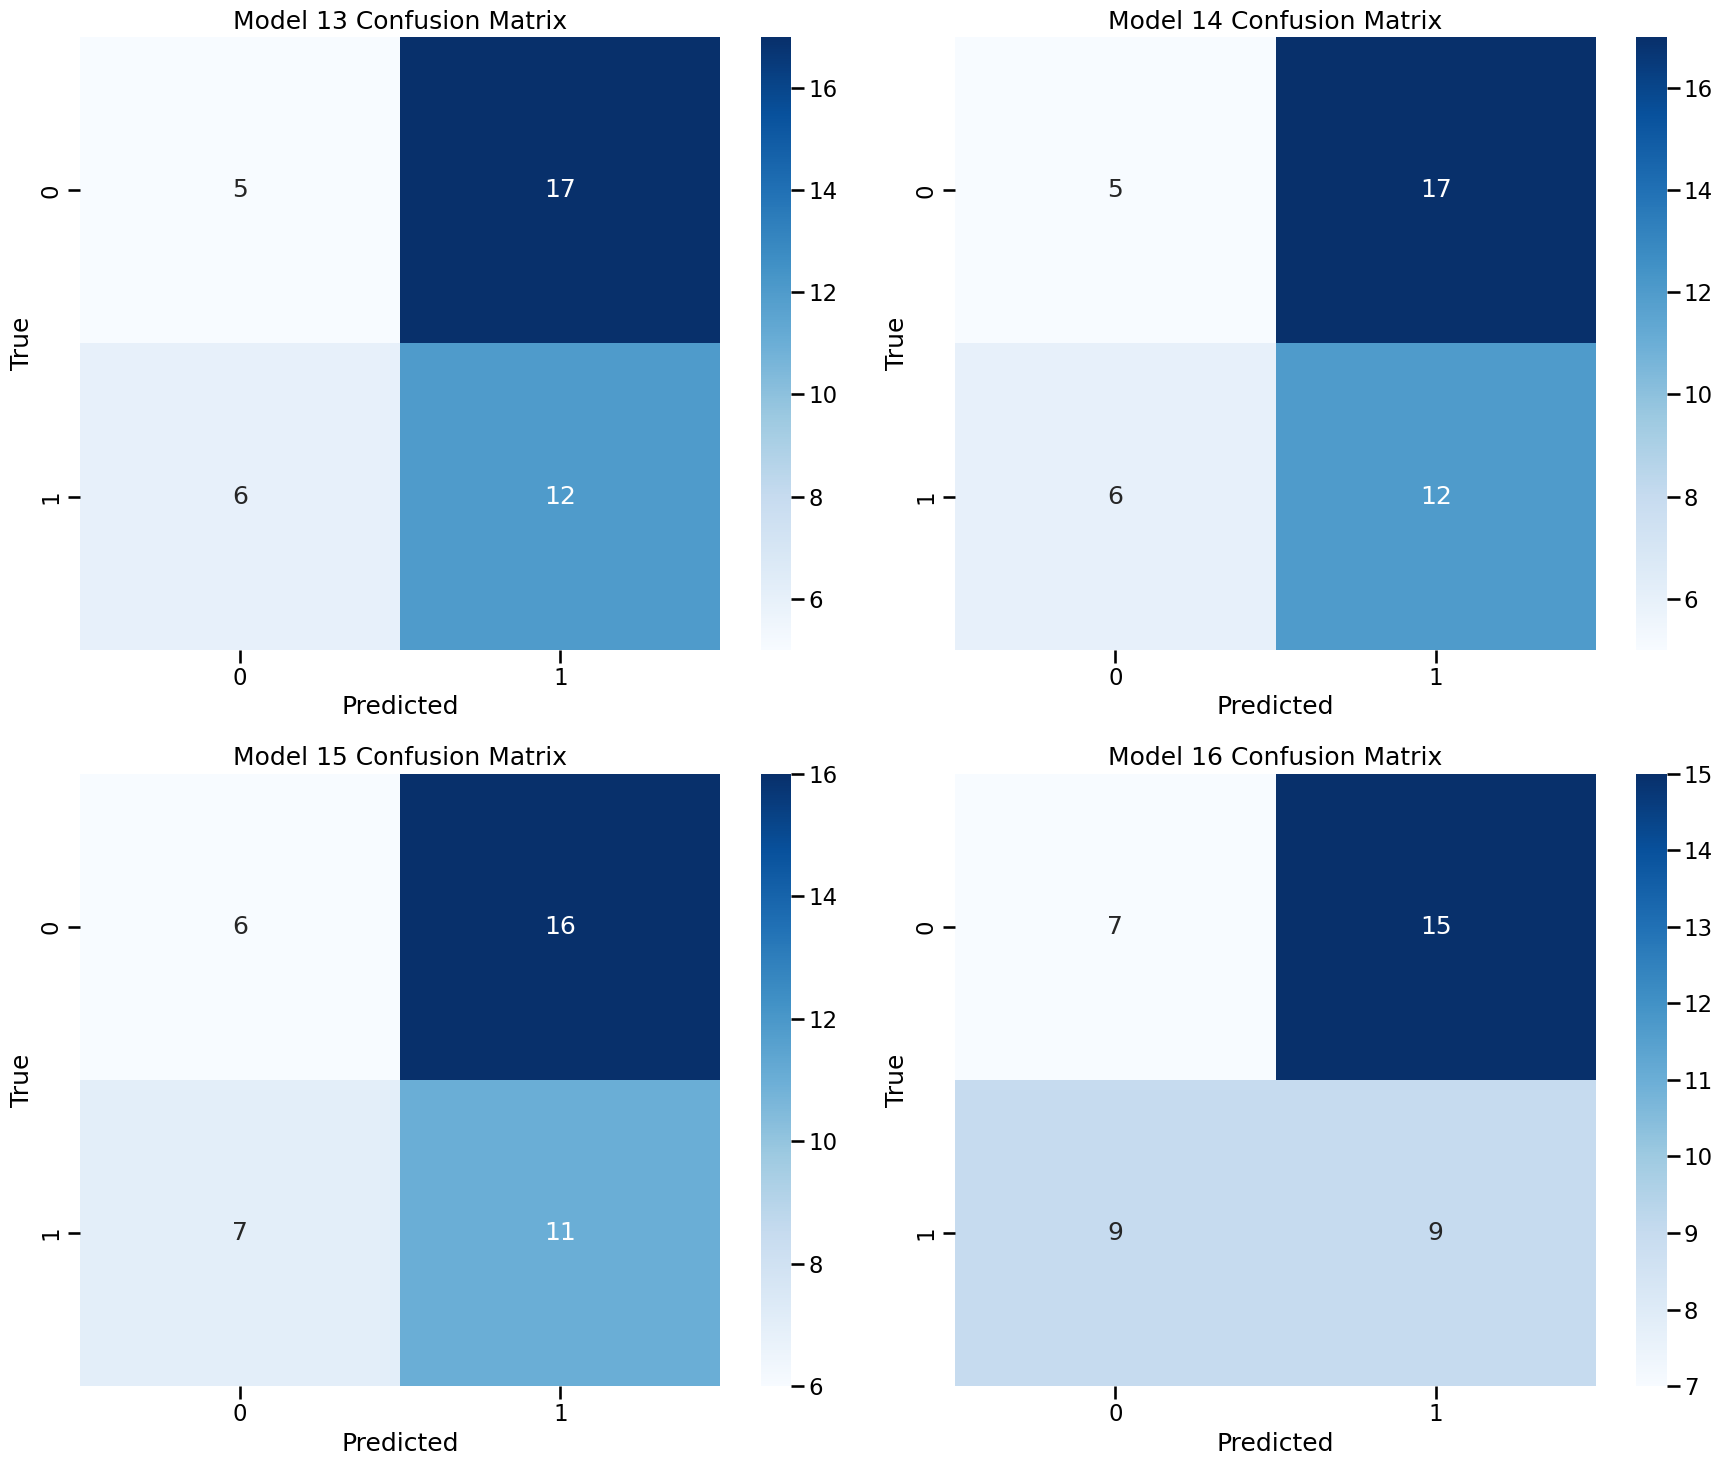

None

In [143]:
# Vectorizing text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Adjust the number of features as needed
tfidf_vectors = tfidf.fit_transform(class_corpus['Processed Text']).toarray()

# Encoding sentiments instead of genres
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(class_corpus['Sentiment'])
labels = to_categorical(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, labels, test_size=0.2, random_state=42)

# Define the models - Adjust input_dim to match the number of features from TF-IDF
input_dim = X_train.shape[1]  # Number of features

# Model Thirteen
model_thirteen = Sequential()
model_thirteen.add(Dense(264, input_dim=input_dim, activation='relu')) 
model_thirteen.add(Dense(labels.shape[1], activation='softmax'))  # Adjust the output layer to match the number of sentiment labels
model_thirteen.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_thirteen = model_thirteen.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_thirteen = model_thirteen.predict(X_test)
pred_thirteen = np.argmax(pred_thirteen, axis=1)

# Model Fourteen
model_fourteen = Sequential()
model_fourteen.add(Dense(512, input_dim=input_dim, activation='relu'))  # More units
model_fourteen.add(Dense(labels.shape[1], activation='softmax'))  # Adjust the output layer
model_fourteen.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_fourteen = model_fourteen.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_fourteen = model_fourteen.predict(X_test)
pred_fourteen = np.argmax(pred_fourteen, axis=1)

# Model Fifteen
model_fifteen = Sequential()
model_fifteen.add(Dense(256, input_dim=input_dim, activation='relu'))  # First dense layer
model_fifteen.add(Dense(128, activation='relu'))  # Second dense layer
model_fifteen.add(Dense(labels.shape[1], activation='softmax'))  # Adjust the output layer
model_fifteen.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_fifteen = model_fifteen.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_fifteen = model_fifteen.predict(X_test)
pred_fifteen = np.argmax(pred_fifteen, axis=1)

# Model Sixteen
model_sixteen = Sequential()
model_sixteen.add(Dense(256, input_dim=input_dim, activation='relu'))  # First dense layer
model_sixteen.add(Dropout(0.5))  # Dropout layer
model_sixteen.add(Dense(128, activation='relu'))  # Second dense layer
model_sixteen.add(Dropout(0.5))  # Another dropout layer
model_sixteen.add(Dense(labels.shape[1], activation='softmax'))  # Adjust the output layer
model_sixteen.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_sixteen = model_sixteen.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=False)
pred_sixteen = model_sixteen.predict(X_test)
pred_sixteen = np.argmax(pred_sixteen, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# Adjusted to reflect the new model names
tfidf_results = evaluate_models(y_test_labels, pred_thirteen, pred_fourteen, pred_fifteen, pred_sixteen)
tfidf_results['Model'] = ['Thirteen', 'Fourteen', 'Fifteen', 'Sixteen']
display(tfidf_results.iloc[:,[-1,0,1,2,3]])

display(plot_confusion_matrices(y_test_labels, 13, pred_thirteen, pred_fourteen, pred_fifteen, pred_sixteen))